In [1]:
import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [51]:
!pip install pyyaml h5py

In [2]:
# Library import code from book
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Personal imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import datetime

from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten, MaxPooling1D, GlobalMaxPool1D
from keras.preprocessing import text

from tensorflow import keras

In [3]:
if torch.cuda.is_available():
    # Create a device object for the GPU
    device = torch.device('cuda')
else:
    # Create a device object for the CPU
    device = torch.device('cpu')
device

device(type='cpu')

In [70]:
!python -m wget http://nlp.stanford.edu/data/glove.6B.zip


Saved under glove.6B.zip


## Loading the train, validation and test datasets

In [4]:
train = pd.read_csv("data/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("data/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("data/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

tweet_df = pd.read_csv("data/tweet_emotions.csv")

go_df = pd.read_csv("data/goemotions_formatted.csv")

In [5]:
# Combine training, validation, and test sets into one and make into DataFrame object
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,11952,i remember two specific things from that class...,fear
1,10178,i feel lonely a class post count link href htt...,sadness
2,15789,i definitely cannot prove but i feel that its ...,joy
3,2158,i posted about feeling like a super mom becaus...,joy
4,10659,i feel like this is something i can do well an...,joy


In [5]:
tweet_df.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


In [6]:
go_df.head()

,Unnamed: 0,Text,ID,anger,fear,joy,sadness,surprise,love
0,0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0,0
1,1,To make her feel threatened,ed7ypvh,0,1,0,0,0,0
2,2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0,0
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1,0
4,4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,0,0,0,1


## Dataset Preprocessing

In [7]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

### EmotionDatasetForNLP

In [8]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 2000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['Input', 'Sentiment']
Numerical columns :  ['index']


,column_name,dtype
0,index,int64
1,Input,object
2,Sentiment,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,index,2000.0,6356.227,4896.124096,10.0,1723.25,5506.0,10526.5,15996.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Input,2000,2000,i would like to reduce the amount of jealousy ...,1
1,Sentiment,2000,6,joy,685


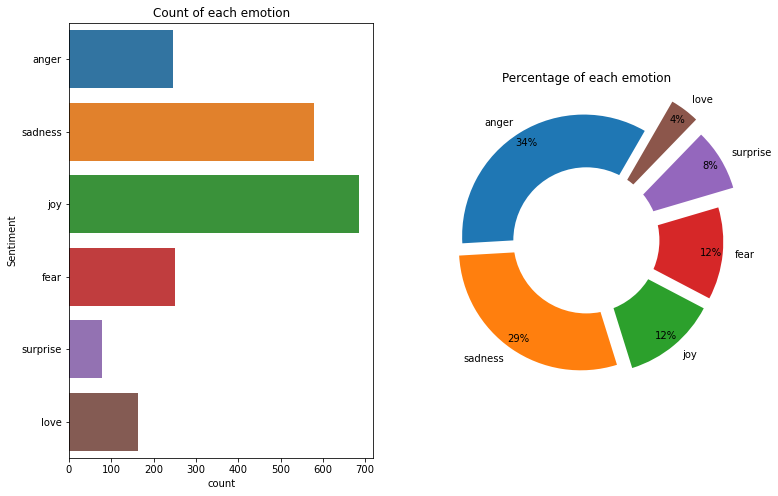

In [9]:
col = 'Sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

### Tweet_Emotions

In [10]:
basic_eda(tweet_df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


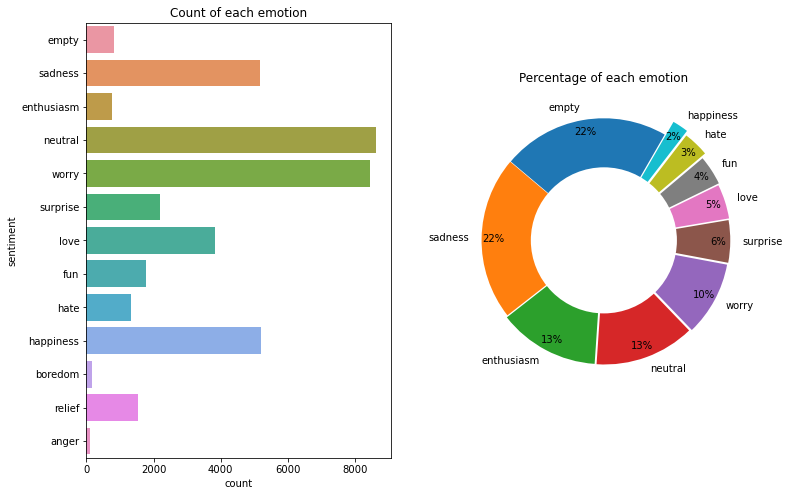

In [11]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(tweet_df[col].dropna().value_counts()))/sum(list(tweet_df[col].dropna().value_counts())))[::-1])[:10]
labels = list(tweet_df[col].dropna().unique())[:10]
sizes = tweet_df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = tweet_df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

Dataset does not have a balanced amount of datapoints for each class, which will cause the model to not converge. A solution is to remove under-represented classes and combine classes into one class.

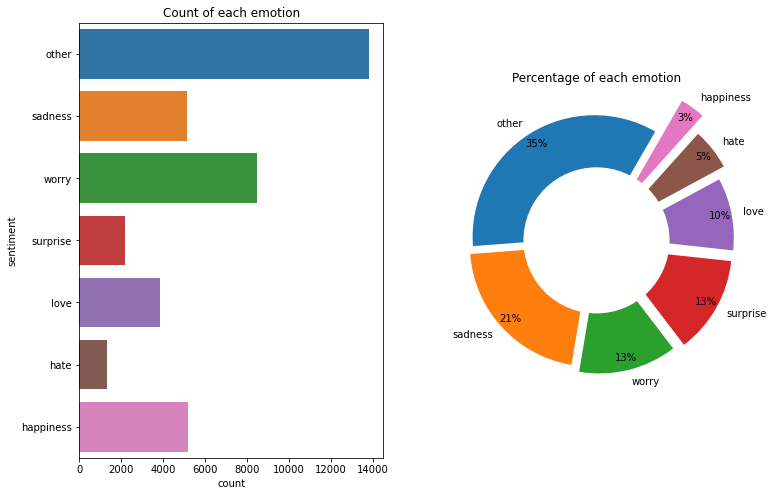

In [12]:
tweet_df['sentiment'] = tweet_df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'surprise', 'love', 'hate'] else "other")
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(tweet_df[col].dropna().value_counts()))/sum(list(tweet_df[col].dropna().value_counts())))[::-1])[:10]
labels = list(tweet_df[col].dropna().unique())[:10]
sizes = tweet_df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = tweet_df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

### GoEmotions Dataset

Robin worked on cleaning up the dataset to be similarly represented as the rest

In [13]:
basic_eda(go_df)

Info : There are 9 columns in the dataset
Info : There are 28427 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 7 numerical columns
Categorical columns :  ['Text', 'ID']
Numerical columns :  ['Unnamed: 0', 'anger', 'fear', 'joy', 'sadness', 'surprise', 'love']


,column_name,dtype
0,Unnamed: 0,int64
1,Text,object
2,ID,object
3,anger,int64
4,fear,int64



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,Unnamed: 0,28427.0,14213.000000,8206.312387,0.0,7106.5,14213.0,21319.5,28426.0
1,anger,28427.0,0.180005,0.384198,0.0,0.0,0.0,0.0,1.0
2,fear,28427.0,0.024167,0.153571,0.0,0.0,0.0,0.0,1.0
3,joy,28427.0,0.297956,0.457368,0.0,0.0,0.0,1.0,1.0
4,sadness,28427.0,0.108488,0.311002,0.0,0.0,0.0,0.0,1.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Text,28427,28301,Thank you.,13
1,ID,28427,28427,eezlygj,1


In [14]:
go_df.head()

,Unnamed: 0,Text,ID,anger,fear,joy,sadness,surprise,love
0,0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0,0
1,1,To make her feel threatened,ed7ypvh,0,1,0,0,0,0
2,2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0,0
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1,0
4,4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,0,0,0,1


### Make each dataset categorical

In [6]:
encoded_conn = {'anger': 0, 'fear': 0, 'joy': 1, 'love': 1, 'sadness': 0, 'surprise': 1} 
encoded_anger = {'anger': 1, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_fear = {'anger': 0, 'fear': 1, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_joy = {'anger': 0, 'fear': 0, 'joy': 1, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_love = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 1, 'sadness': 0, 'surprise': 0}
encoded_sadness = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 1, 'surprise': 0}
encoded_surprise = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 1}

tweet_conn = {'hate': 0, 'worry': 0, 'happiness': 1, 'love': 1, 'sadness': 0, 'surprise': 1, 'other': 0} 
tweet_anger = {'hate': 1, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_fear = {'hate': 0, 'worry': 1, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_joy = {'hate': 0, 'worry': 0, 'happiness': 1, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_love = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 1, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_sadness = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 1, 'surprise': 0, 'other': 0}
tweet_surprise = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 1, 'other': 0}

In [7]:
df['anger'] = df.Sentiment.map(encoded_anger)
df['fear'] = df.Sentiment.map(encoded_fear)
df['joy'] = df.Sentiment.map(encoded_joy)
df['love'] = df.Sentiment.map(encoded_love)
df['sadness'] = df.Sentiment.map(encoded_sadness)
df['surprise'] = df.Sentiment.map(encoded_surprise)
df['connotation'] = df.Sentiment.map(encoded_conn)
df.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
0,11952,i remember two specific things from that class...,fear,0,1,0,0,0,0,0
1,10178,i feel lonely a class post count link href htt...,sadness,0,0,0,0,1,0,0
2,15789,i definitely cannot prove but i feel that its ...,joy,0,0,1,0,0,0,1
3,2158,i posted about feeling like a super mom becaus...,joy,0,0,1,0,0,0,1
4,10659,i feel like this is something i can do well an...,joy,0,0,1,0,0,0,1


In [9]:
df.to_csv("data/smallData_formatted.csv", index=False)

In [17]:
tweet_df['anger'] = tweet_df.sentiment.map(tweet_anger)
tweet_df['fear'] = tweet_df.sentiment.map(tweet_fear)
tweet_df['joy'] = tweet_df.sentiment.map(tweet_joy)
tweet_df['love'] = tweet_df.sentiment.map(tweet_love)
tweet_df['sadness'] = tweet_df.sentiment.map(tweet_sadness)
tweet_df['surprise'] = tweet_df.sentiment.map(tweet_surprise)
tweet_df['connotation'] = tweet_df.sentiment.map(tweet_conn)
tweet_df.rename(columns={'content': 'Input'}, inplace=True)
tweet_df.tail()

,tweet_id,sentiment,Input,anger,fear,joy,love,sadness,surprise,connotation
39995,1753918954,other,@JohnLloydTaylor,0,0,0,0,0,0,0
39996,1753919001,love,Happy Mothers Day All my love,0,0,0,1,0,0,1
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,0,0,0,1,0,0,1
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0,0,1,0,0,0,1
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...,0,0,0,1,0,0,1


In [18]:
#combined_df = pd.merge(df, tweet_df)
#combined_df

## Train-Test Split

In [89]:
# Stratify: Split in a stratified fashion using the class labels, which in this case is under the column header 'Sentiment'
train_data, test_data = train_test_split(df,test_size=0.3,random_state=101,shuffle=True,stratify=df.Sentiment)

In [91]:
# For using tweet dataset
train_data, test_data = train_test_split(tweet_df,test_size=0.3,random_state=101,shuffle=True,stratify=tweet_df.sentiment)

In [92]:
#train_data['Label'] = train_data.Sentiment.map(encoded_labels)
#test_data['Label'] = test_data.Sentiment.map(encoded_labels)
train_data.head()

,tweet_id,sentiment,Input,anger,fear,joy,love,sadness,surprise,connotation
37146,1753434709,love,@chantelleaustin Good one,0,0,0,1,0,0,1
35612,1753138237,other,@nitesofsuburbia that's SO YOU!,0,0,0,0,0,0,0
2868,1957641646,happiness,Nevermind! Beyonce doesn't have a Twitter Haha,0,0,1,0,0,0,1
9850,1962726989,hate,ughh on the phone with HP!,1,0,0,0,0,0,0
39842,1753886131,happiness,"@cssglobe hahah, you own lab.hr I own lab.ba,...",0,0,1,0,0,0,1


In [93]:
test_data.head()

,tweet_id,sentiment,Input,anger,fear,joy,love,sadness,surprise,connotation
9637,1962660094,other,@freckleface3 I am trying but I can't place it...,0,0,0,0,0,0,0
12657,1963649972,happiness,"#bgt Aw bless her, my stomach sank when she fi...",0,0,1,0,0,0,1
11531,1963270384,surprise,I wonder why thumbnail pictures aren't showing...,0,0,0,0,0,1,1
23521,1694644439,other,@kbphotos You are an early bird too I see?!?!,0,0,0,0,0,0,0
12900,1963755435,other,Chaz's Daily Happenings: 22:31 Watching E.R in...,0,0,0,0,0,0,0


## Naive Training by converting text to:
+ Bag of Words: Translates a string to a vector that is the length of number of words in the string, with each index
    representing the number of times a word occurs in a string.
    + Problem: Losses order of words, which is critical for the english language
+ Character Encoding: Encodes the individual characters in a string
    + Problem: Losses concept of words, becomes a very generative approach for our purpose
+ Word Embedding: Transforms each word into number vectors for a given string. The embeddings can be calculated for
    your given dataset, but you could just use pre-computed embeddings.
    + GloVe + word2vec: Embeddings contain a mathematical sense to their numbers by implementing semantic information in the embedding process. For instance, [king] - [man] + [woman] = [queen]

Fixed size vectors means padding needs to be added to the strings to ensure all will be the same length in words

In [96]:
# set parameters:
vocab_size = 1000
maxlen = 300
batch_size = 32
embedding_dims = 50
filters =250
kernel_size = 3
hidden_dims = 100
epochs = 10

In [97]:
# Split to X and Y
labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
X_train = train_data['Input']
X_train.head()
Y_train = train_data[labels]
Y_train.head()
X_test = test_data['Input']
Y_test = test_data[labels]
Y_test.head()

Yconn_train = train_data['connotation']
Yconn_test = test_data['connotation']
Yconn_train.head()

37146    1
35612    0
2868     1
9850     0
39842    1
Name: connotation, dtype: int64

In [98]:
# Tokenizer: Ensures inputs that are longer than max vocab size are removed to ensure same size vectors
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [99]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [103]:
embeddings_index = dict()
f = open('glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [104]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [100]:
# Model (without embedding)
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(128,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 50)           50000     
                                                                 
 dropout_10 (Dropout)        (None, 300, 50)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 298, 128)          19328     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 149, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 147, 64)           24640     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 73, 64)           0         
 g1D)                                                 

In [105]:
# Model (with embedding)
model = Sequential()
model.add(Embedding(vocab_size,
                    100,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(128,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 100)          100000    
                                                                 
 dropout_12 (Dropout)        (None, 300, 100)          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 300, 128)          38528     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 150, 64)           24640     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 75, 64)           0         
 g1D)                                                 

In [106]:
lr = 1e-5;
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [107]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_test, Y_test))

Epoch 1/20
875/875 [==============================] - 21s 24ms/step - loss: 1.1723 - accuracy: 0.1951 - val_loss: 1.1431 - val_accuracy: 0.2115
Epoch 2/20
875/875 [==============================] - 21s 24ms/step - loss: 1.1490 - accuracy: 0.2024 - val_loss: 1.1393 - val_accuracy: 0.2115
Epoch 3/20
875/875 [==============================] - 21s 24ms/step - loss: 1.1499 - accuracy: 0.1997 - val_loss: 1.1345 - val_accuracy: 0.2115
Epoch 4/20
875/875 [==============================] - 21s 24ms/step - loss: 1.1657 - accuracy: 0.1953 - val_loss: 1.1300 - val_accuracy: 0.2115
Epoch 5/20
875/875 [==============================] - 21s 24ms/step - loss: 1.1954 - accuracy: 0.1955 - val_loss: 1.1207 - val_accuracy: 0.2114
Epoch 6/20
875/875 [==============================] - 21s 24ms/step - loss: 1.2680 - accuracy: 0.1932 - val_loss: 1.1174 - val_accuracy: 0.2113
Epoch 7/20
875/875 [==============================] - 22s 25ms/step - loss: 1.3675 - accuracy: 0.1925 - val_loss: 1.1144 - val_accuracy:

In [81]:
model.save('models/CNN_smallData_Embedded.h5')

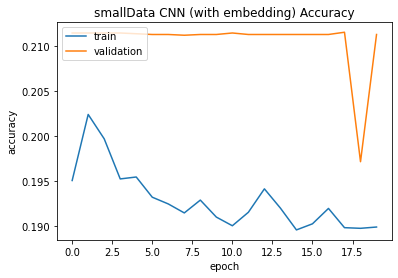

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('smallData CNN (with embedding) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

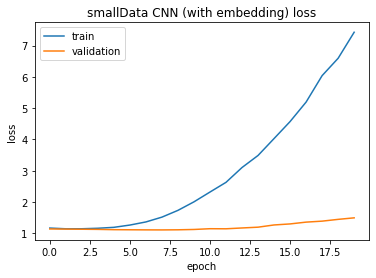

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('smallData CNN (with embedding) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix
Y_pred = np.argmax(history.predict(X_test),axis=1)
print('Confusion Matrix')
print(multilabel_confusion_matrix(y_test, Y_pred))
print('Classification Report')

AttributeError: 'History' object has no attribute 'predict'

In [ ]:
#@tab pytorch
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

## Using Pretrained BERT Model

In [131]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers.legacy import Adam as legacyAdam

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stanl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
train = pd.read_csv("data/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("data/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("data/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')